# tracking the detected pupil: visual inspection of the results



In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
np.set_printoptions(precision=2, suppress=True)
# define plots to be inserted interactively
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Using 42 frames recorded with 2015-11-05 notebook


In [2]:
import cv2
import os

N_frame = 42

folder = '/tmp/debug'
H, W, three = cv2.imread(os.path.join(folder, 'frame_1.png')).shape

movie = np.zeros((H, W, 3, N_frame), dtype=np.uint8)

for i in range(N_frame):
    fname = 'frame_{i}.png'.format(i=i)
    movie[:, :, :, i] = cv2.cvtColor(cv2.imread(os.path.join(folder, fname)), cv2.COLOR_BGR2RGB)


(720, 1280, 3, 42) 0 255


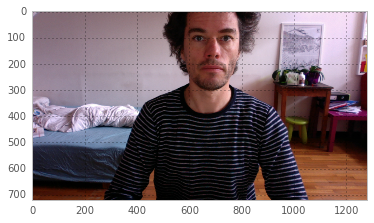

In [3]:
print(movie.shape, movie.min(), movie.max())
plt.imshow(movie[:, :, :, 0])

/usr/local/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


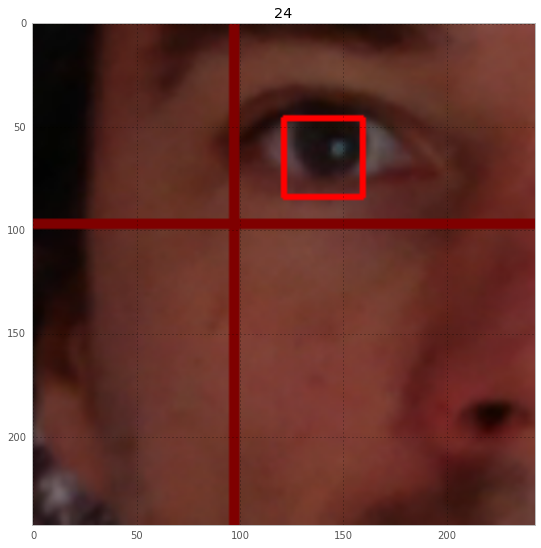

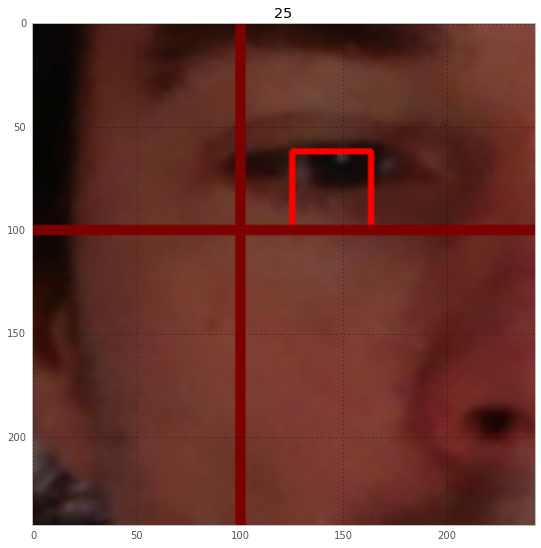

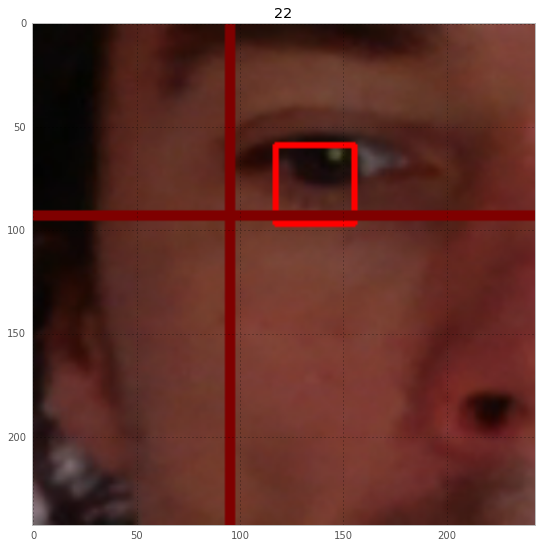

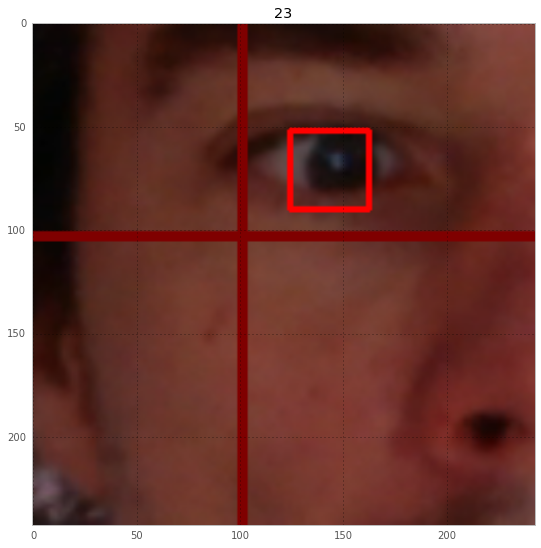

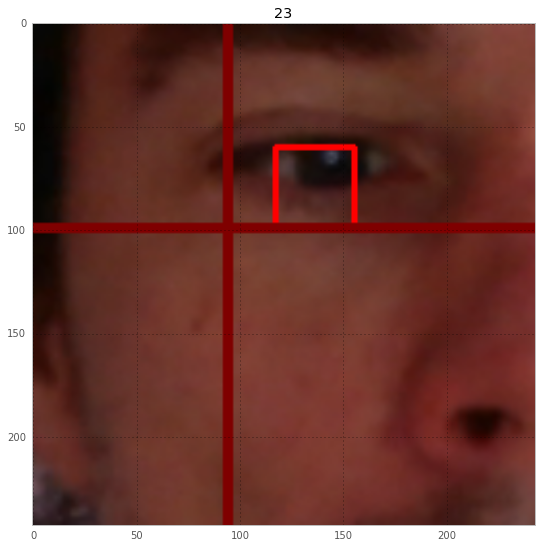

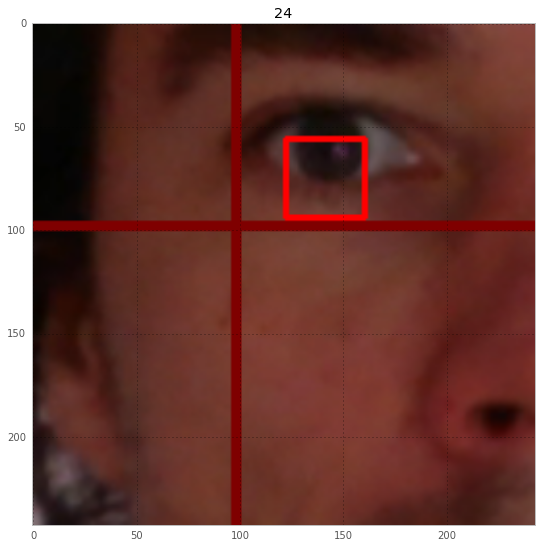

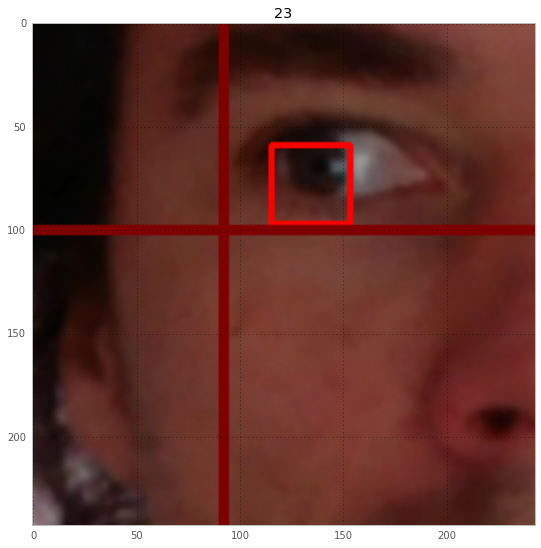

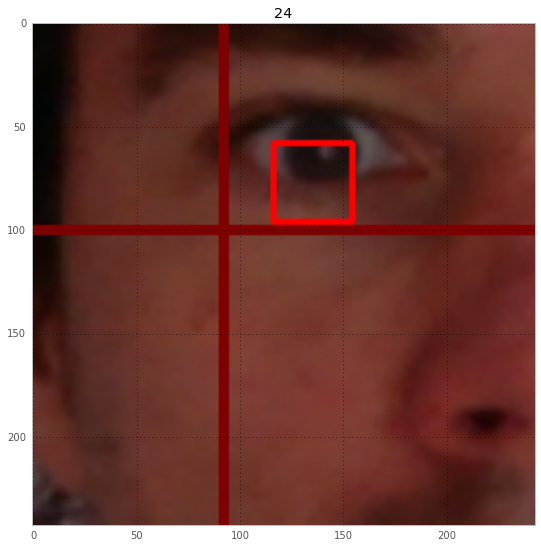

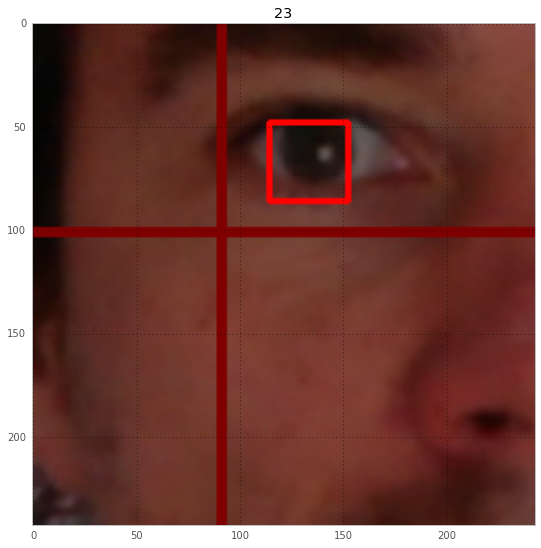

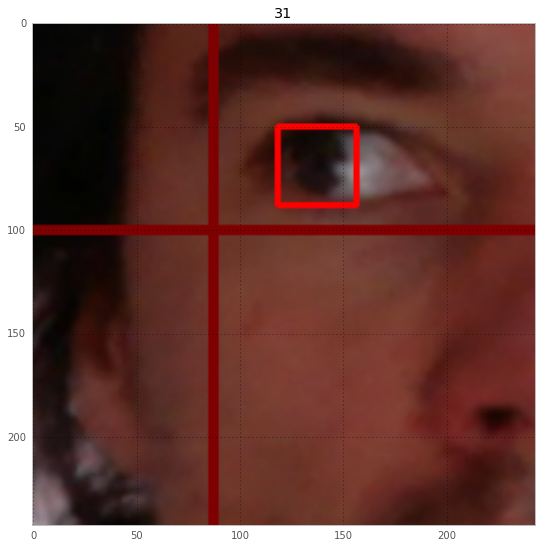

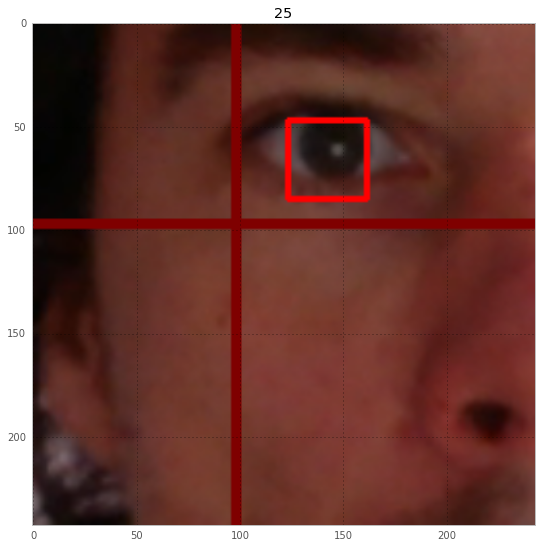

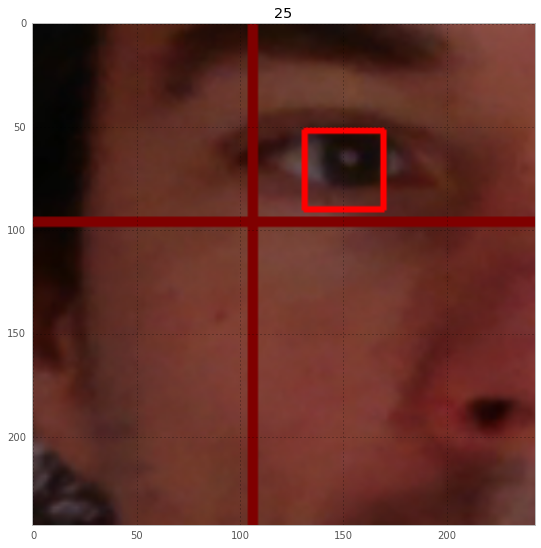

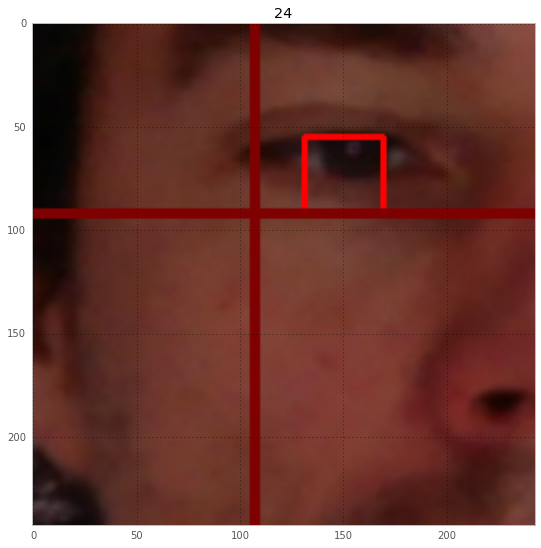

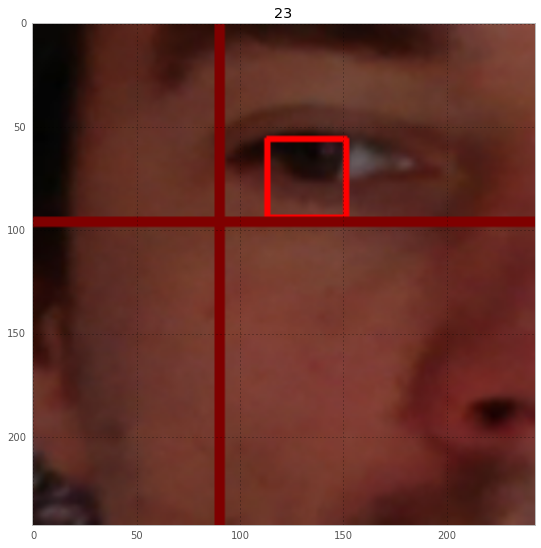

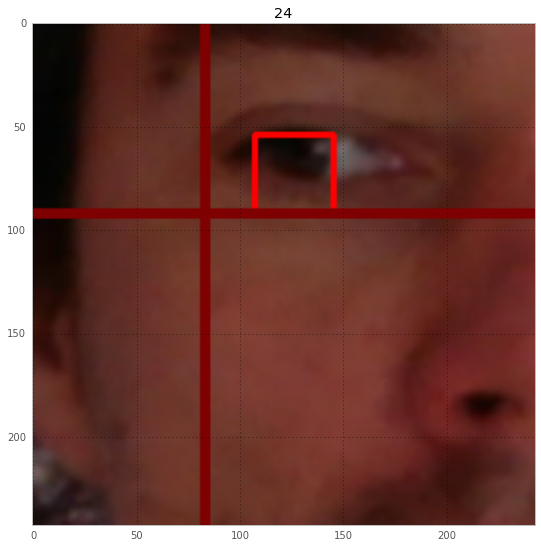

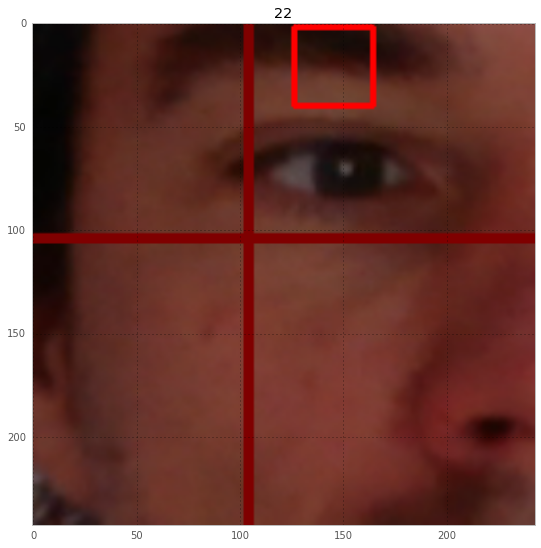

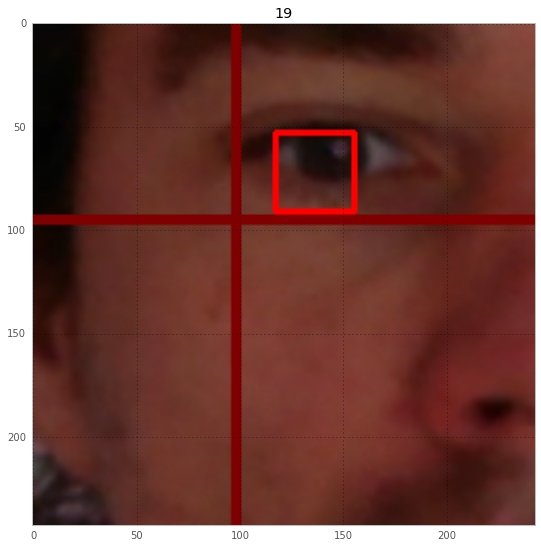

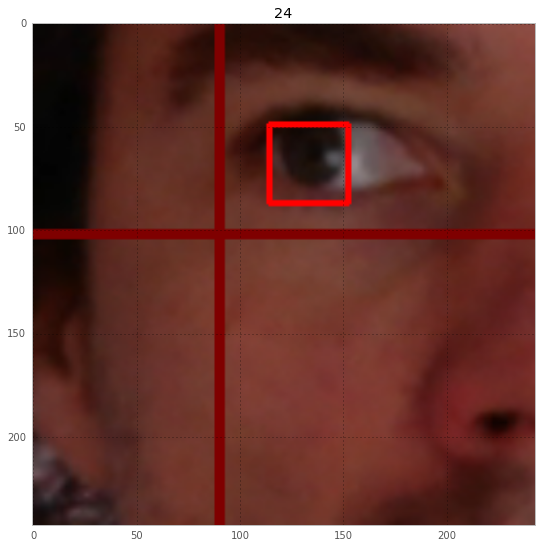

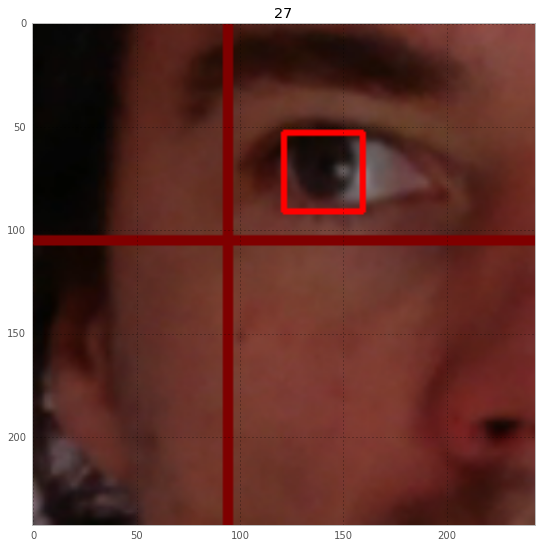

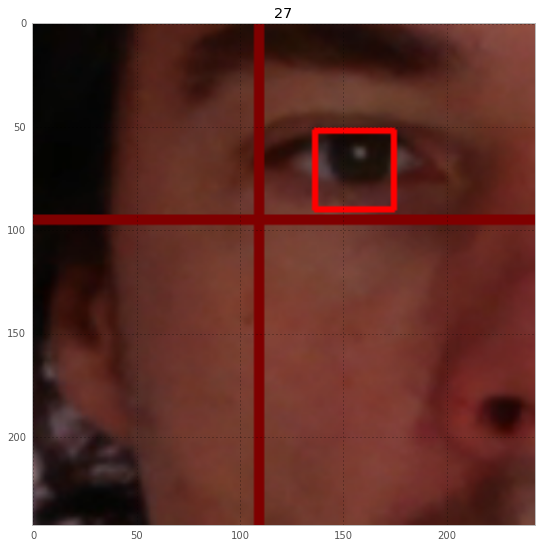

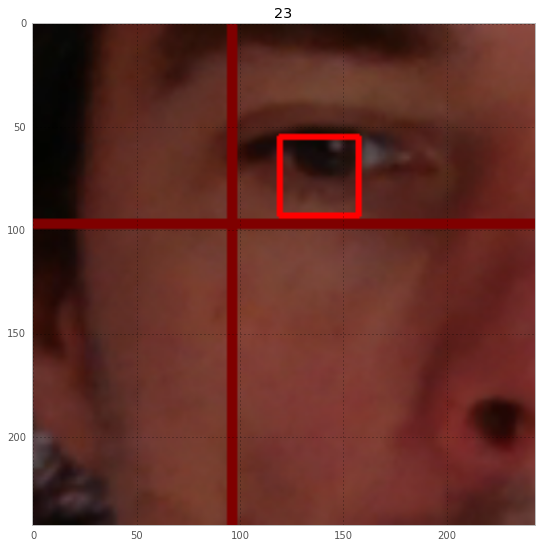

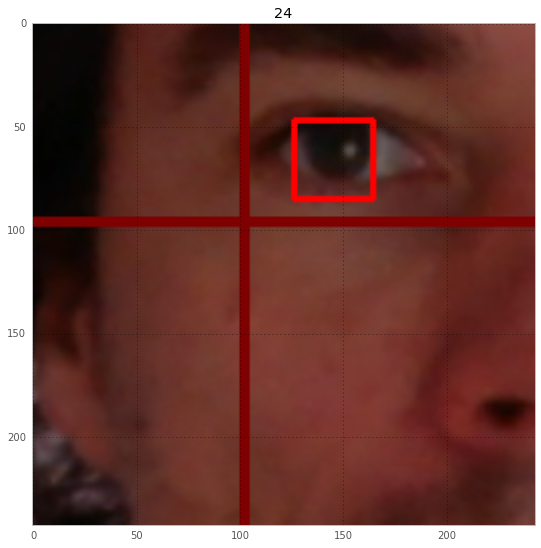

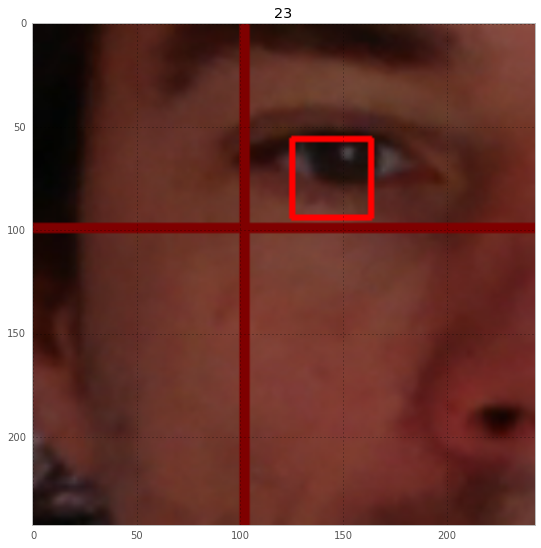

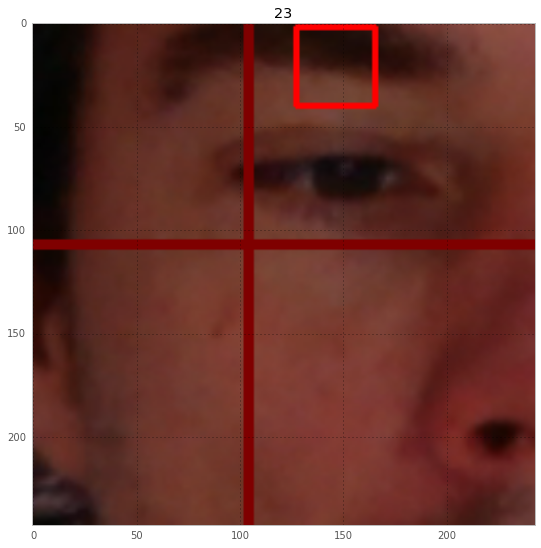

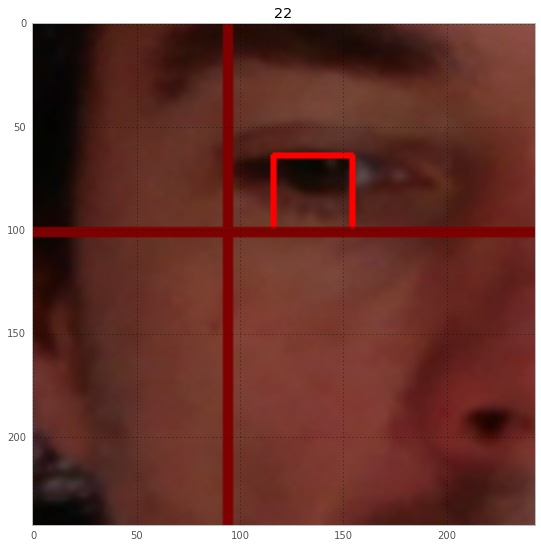

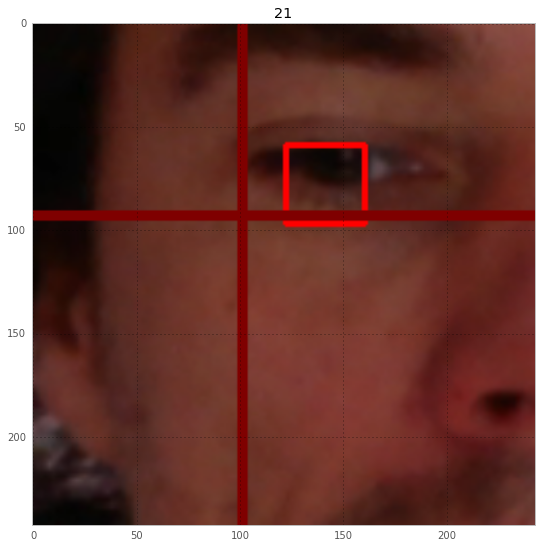

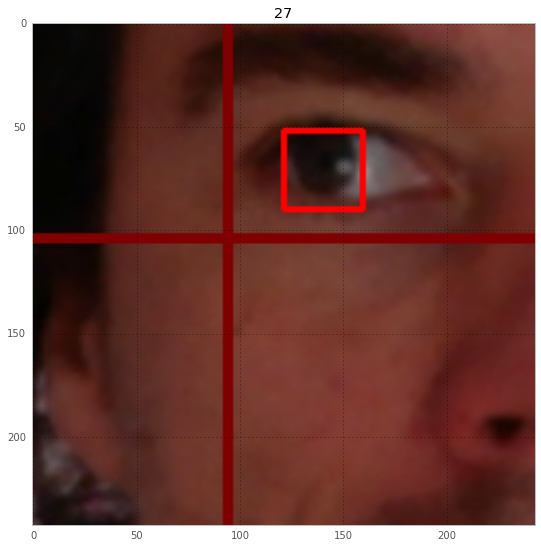

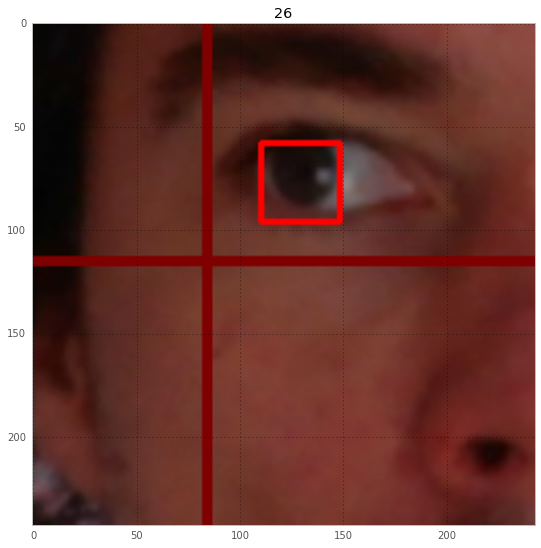

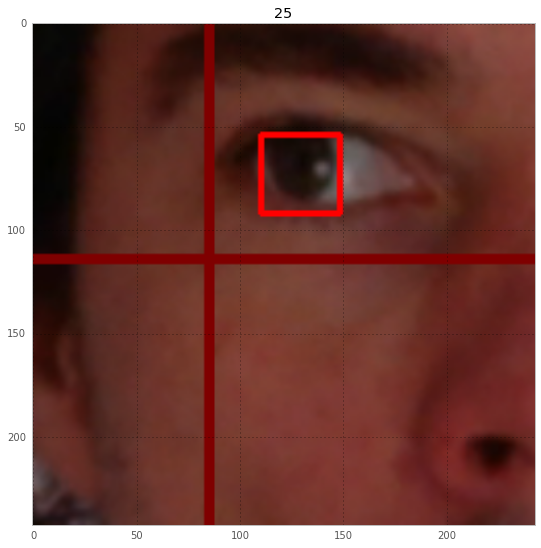

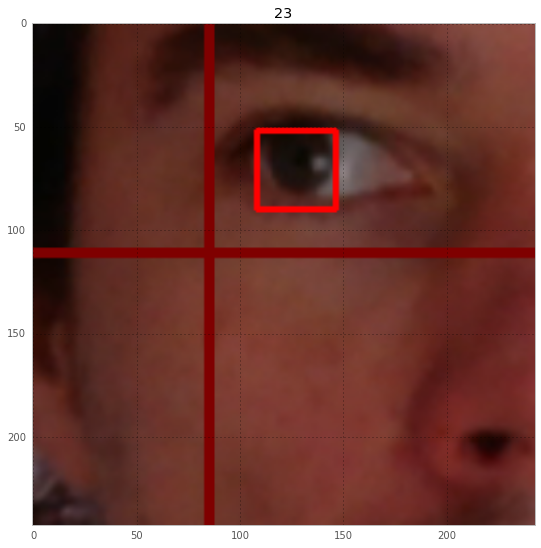

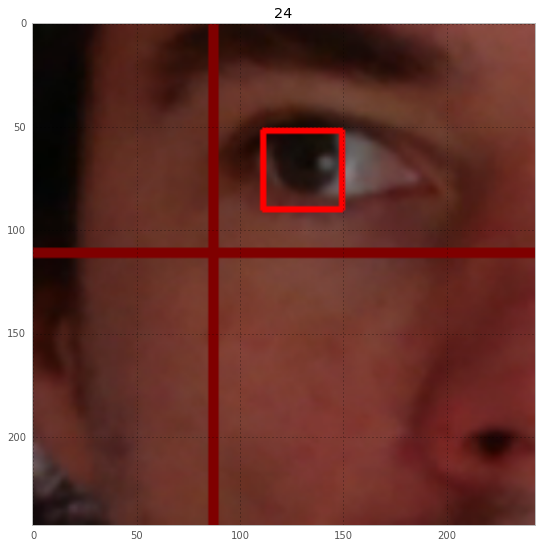

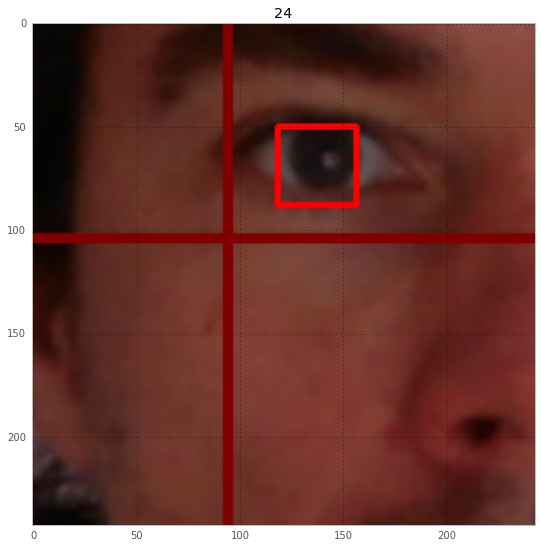

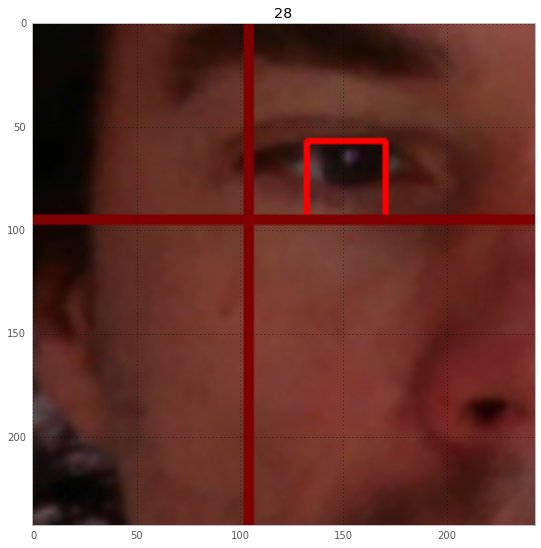

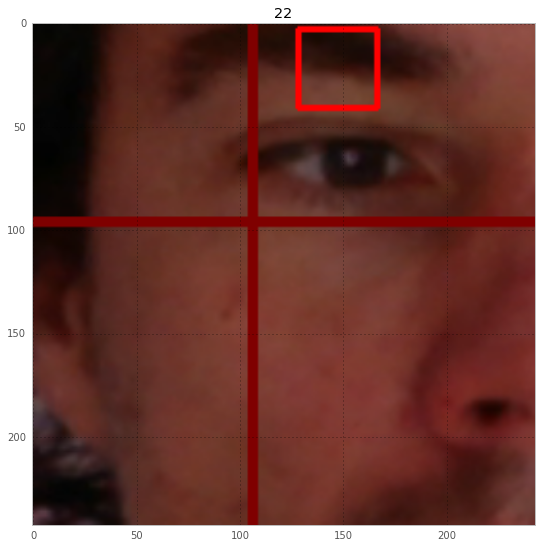

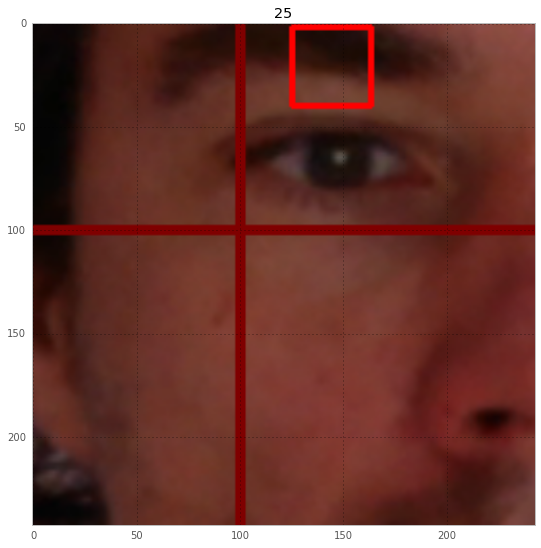

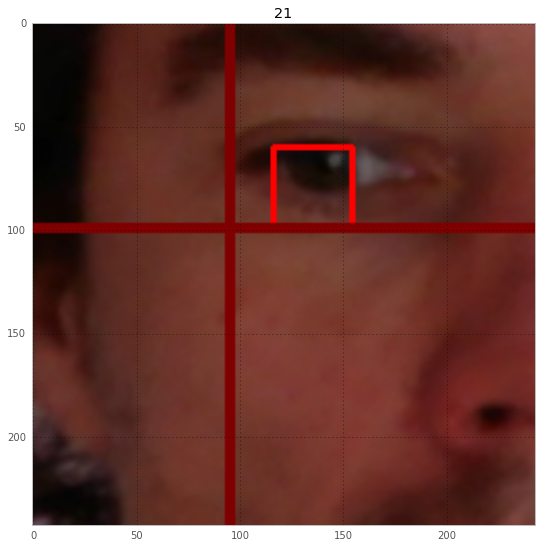

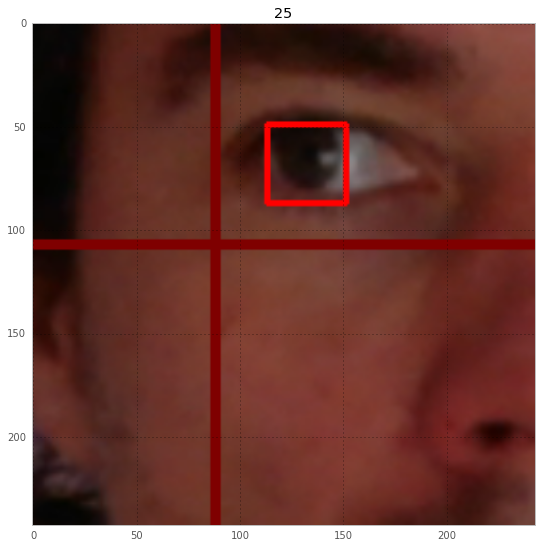

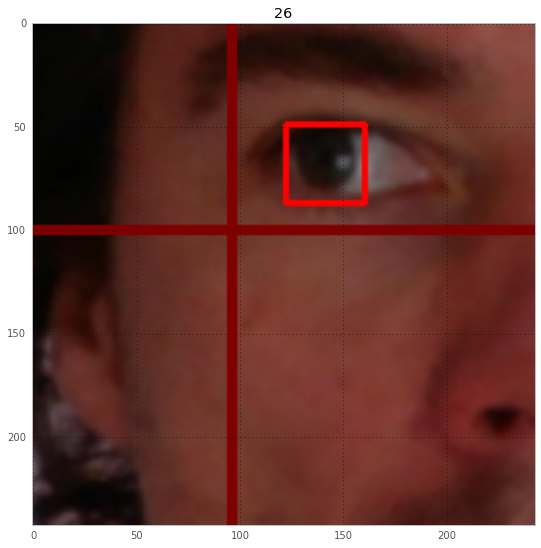

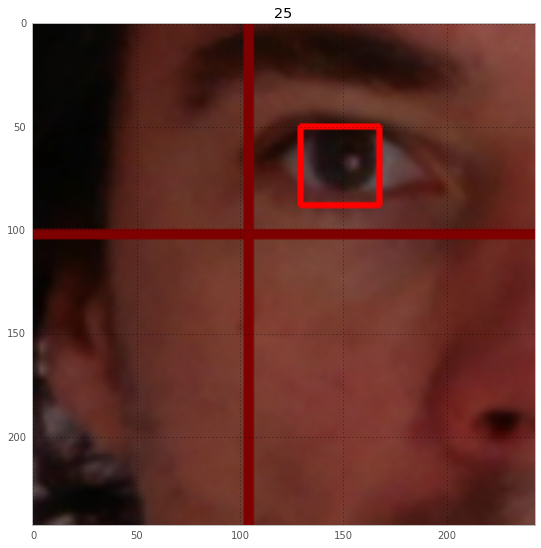

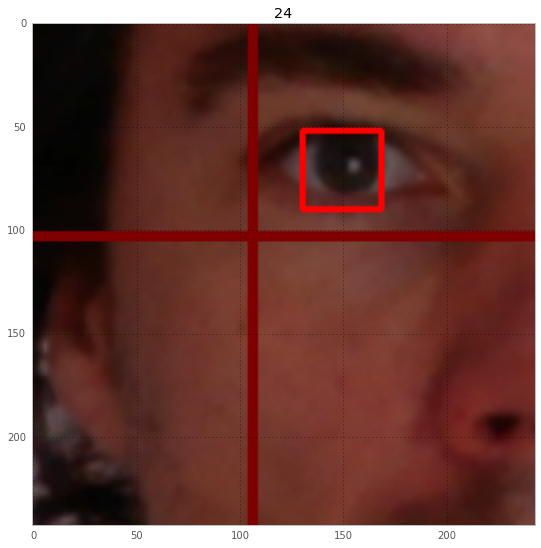

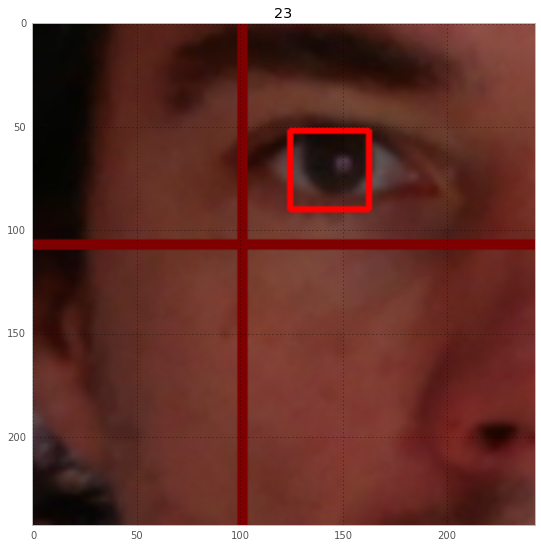

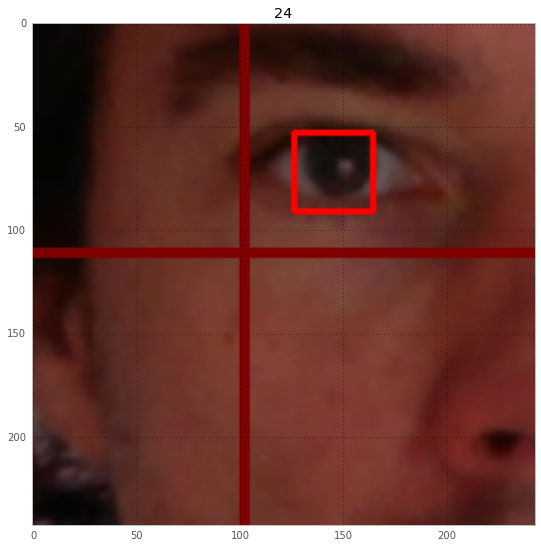

In [6]:
from LeCheapEyeTracker import Client, Server
et = Server()
img_ = movie[:, :, :, 0].copy()


import time
start = time.time()
import cv2
#cam.head_size = 452
face_cascade = cv2.CascadeClassifier('/usr/local/Cellar/opencv3/3.1.0_1/share/OpenCV/haarcascades/haarcascade_frontalface_default.xml')
#from LeCheapEyeTracker.constants import face_cascade

#eye_template = cv2.imread('../src/my_eye.png')
from LeCheapEyeTracker.constants import eye_image as eye_template

def get_just_one(image, cascade):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # We set set minNeighbors=1 then increase it until we have one face only - same for eyes see http://stackoverflow.com/questions/22249579/opencv-detectmultiscale-minneighbors-parameter
    features, minNeighbors = [], 1
    while len(features) == 0 and minNeighbors<20:
        features = cascade.detectMultiScale(image, 1.1, minNeighbors) # image[, scaleFactor[, minNeighbors[, flags[, minSize[, maxSize]
        minNeighbors += 1
        #print(minNeighbors)
    return features[0], minNeighbors


#eye_template = cv2.Laplacian(eye_template, cv2.CV_64F)
#face_template = np.zeros((et.head_size//2, et.head_size//2, 3))
wt, ht = eye_template.shape[1], eye_template.shape[0]
for i_t in range(N_frame):
    img_ = movie[:, :, :, i_t].copy()
    (x, y, w, h), minNeighbors = get_just_one(img_, face_cascade)
    #print(w, h)
    #img_face = img_[y:y+h, x:x+w]
    half_w, quarter_w = w//2, w//4
    img_face = img_[(y+quarter_w):(y+quarter_w+half_w), x:x+half_w]
    img_face = cv2.resize(img_face, (et.head_size//2, et.head_size//2))

#    res = cv2.matchTemplate(cv2.Laplacian(img_face, cv2.CV_32F,ksize=15), cv2.Laplacian(eye_template, cv2.CV_32F,ksize=15), cv2.TM_CCOEFF)
    res = cv2.matchTemplate(img_face, eye_template, cv2.TM_CCOEFF)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    #print(min_val, max_val, min_loc, max_loc)
    bottom_right = (max_loc[0] + wt, max_loc[1] + ht)

    # detect vertical shift
#    if i_t==0: face_template = cv2.Laplacian(img_face, cv2.CV_32F)[int(et.head_size*.2):int(et.head_size*.4), :, :]
#    res = cv2.matchTemplate(cv2.Laplacian(img_face, cv2.CV_32F), face_template, cv2.TM_CCOEFF)
    if i_t==0: face_template_v = cv2.Sobel(img_face, cv2.CV_32F,0,1,ksize=5)[int(et.head_size*.2):int(et.head_size*.4), :, :]
    res = cv2.matchTemplate(cv2.Sobel(img_face, cv2.CV_32F,0,1,ksize=5), face_template_v, cv2.TM_CCOEFF)
    #if i_t==0: face_template = img_face[int(et.head_size//2*.6):int(et.head_size//2*.9), :, :]
    #res = cv2.matchTemplate(img_face, face_template, cv2.TM_CCOEFF)
    __min_val, __max_val, _min_loc, face_max_loc = cv2.minMaxLoc(res)
    face_v_top_left = (0, face_max_loc[1] - 1)
    face_v_bottom_right = (et.head_size, face_max_loc[1] + 1)
    #print(face_max_loc[1])
    # detect horizontal shift
    if i_t==0: face_template_h = cv2.Sobel(img_face, cv2.CV_32F,1,0,ksize=5)[:, int(et.head_size*.2):int(et.head_size*.4), :]
    res = cv2.matchTemplate(cv2.Sobel(img_face, cv2.CV_32F,1,0,ksize=5), face_template_h, cv2.TM_CCOEFF)
    #if i_t==0: face_template = img_face.copy()[:, int(et.head_size*.125):int(et.head_size*.25), :]
    #res = cv2.matchTemplate(img_face, face_template, cv2.TM_CCOEFF)
    __min_val, __max_val, _min_loc, face_max_loc = cv2.minMaxLoc(res)
    face_h_top_left = (face_max_loc[0] - 1, 0)
    face_h_bottom_right = (face_max_loc[0] + 1, et.head_size)

    cv2.rectangle(img_face, max_loc, bottom_right, 255, 2)
    cv2.rectangle(img_face, face_h_top_left, face_h_bottom_right, 127, 2)
    cv2.rectangle(img_face, face_v_top_left, face_v_bottom_right, 127, 2)
    fig, axs = plt.subplots(1, 1, figsize=(9, 9))
    #axs.imshow(img_face[:et.head_size//4:, :, :])
    axs.imshow(img_face)
    axs.set_title(max_loc[0] - face_max_loc[0])
